In [2]:
import torch
import pickle
import os
import os.path as osp
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io
import pandas as pd

from analysis_utils import make_heatmap
from run_analysis import last_n_layer_att, decompose_att_vector
from refxp_processor import RefExpProcessor

In [3]:
import sys

sys.path.append(os.pardir)
from inference.inference_utils import override_config_with_checkpoint

sys.path.append(osp.abspath(osp.join(os.pardir, 'model')))
from configuration import Config
from data_utils.utils import get_refcoco_df
from eval_utils.decode import prepare_tokenizer

config = Config()

processor = RefExpProcessor('en_core_web_trf')

In [4]:
def filename_from_id(image_id, prefix='', file_ending='.jpg'):
    """
    get image filename from id: pad image ids with zeroes,
    add file prefix and file ending
    """
    padded_ids = str(image_id).rjust(12, '0')
    filename = prefix + padded_ids + file_ending

    return (filename)


def patches_from_bb(e, linewidth=2, edgecolor="g", facecolor="none"):
    bbox = e.bbox
    # Create a Rectangle patch
    return patches.Rectangle(
        (bbox[0], bbox[1]),
        bbox[2],
        bbox[3],
        linewidth=linewidth,
        edgecolor=edgecolor,
        facecolor=facecolor,
    )


def display_target_distractors(
    entry_id,
    refcoco_data,
    coco_base,
    linewidth=2,
    target_color="g",
    distractor_color="r",
    facecolor="none",
    dpi='figure',
    save=False
):
    
    # get entry
    entry = refcoco_data.loc[entry_id]
    
    # Create figure and axes
    _, ax = plt.subplots(figsize=(10, 10))

    # Retrieve & display the image
    image_file = filename_from_id(entry.image_id, prefix='COCO_train2014_')
    image_filepath = osp.join(coco_base, 'train2014', image_file)
    image = io.imread(image_filepath)
    ax.imshow(image)

    # Add the patch to the Axes
    ax.add_patch(
        patches_from_bb(
            entry, edgecolor=target_color, linewidth=linewidth, facecolor=facecolor
        )
    )

    if type(refcoco_data) == pd.core.frame.DataFrame:

        # add patches for distractors
        add_patch = lambda x: ax.add_patch(
            patches_from_bb(
                x, edgecolor=distractor_color, linewidth=linewidth, facecolor=facecolor
            )
        )

        distractors = (
            refcoco_data.loc[refcoco_data.image_id == entry.image_id]
            .loc[refcoco_data.ann_id != entry.ann_id]
            .groupby("ann_id")
            .first()
        )

        distractors.apply(lambda x: add_patch(x), axis=1)
        
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    if save:
        print(entry)
        filename = f'example_{entry.image_id}_{entry.name}.jpg'
        plt.savefig(filename, bbox_inches='tight', dpi=dpi)
        print(f'saved to {filename}')

    plt.show()


def reshape_2d_att(att, wh_dim=14):
    """reshape a 1d attention vector into a 2d attention vector"""
    assert att.shape[-1] == wh_dim**2
    return att.reshape(14,14)

In [5]:
data_dir = os.path.join(os.pardir, 'data', 'results')
print(os.listdir(data_dir))

path_base = 'concat_refcoco_loc_glob_checkpoint_5_testb_'

generated_file = path_base + 'generated.pkl'
model_file = re.sub(r'_(val|testa|testb|test)_', '', path_base) + '.pth'

override_config_with_checkpoint(model_file, config)

generated_path = os.path.join(data_dir, generated_file)
with open(generated_path, 'rb') as f:
    generated_data = pickle.load(f)

['concat_refcoco_loc_glob_checkpoint_5_testb_eval.json', 'concat_refcoco_loc_glob_checkpoint_5_testa_eval.json', 'concat_refcoco+_loc_glob_checkpoint_7_val_eval.json', 'concat_refcocog_loc_glob_checkpoint_5_val_eval.json', 'concat_refcoco_loc_glob_checkpoint_5_val_analysis_last6.json', 'concat_refcoco+_loc_glob_checkpoint_7_testa_generated.pkl', 'concat_refcoco_loc_glob_checkpoint_5_testa_generated.pkl', 'concat_refcoco_loc_glob_checkpoint_5_testb_generated.pkl', 'concat_refcocog_loc_glob_checkpoint_5_val_generated.pkl', 'concat_refcoco+_loc_glob_checkpoint_7_val_generated.pkl', 'analysis_outputs', 'concat_refcoco_loc_glob_checkpoint_5_val_generated.pkl', 'concat_refcoco+_loc_glob_checkpoint_7_testb_eval.json', 'concat_refcoco+_loc_glob_checkpoint_7_testa_eval.json', 'concat_refcoco_loc_glob_checkpoint_5_val_eval.json', '.gitkeep', 'concat_refcoco+_loc_glob_checkpoint_7_testb_generated.pkl']
CAUTION: Overriding configuration!
                WAS: prefix==refcocog;
                NEW: 

In [6]:
tokenizer, _, _ = prepare_tokenizer()

# prepare refcoco df

refcoco_df = get_refcoco_df(config.ref_dir)

refcoco_df = refcoco_df.reset_index().groupby('ann_id').agg({
    'sent_id': list, 'caption': list, 
    'ref_id': 'first', 'refcoco_split': 'first', 
    'coco_split': 'first', 'image_id': 'first', 
    'bbox': 'first', 'category_id':'first',
}).reset_index()

refcoco_df.index = refcoco_df.ann_id.values

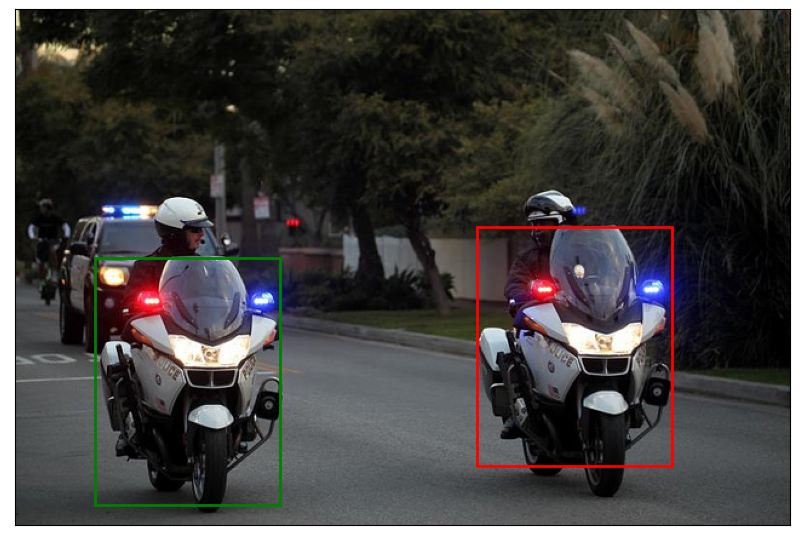

annotated:
left bike
motorcycle on the left
left cycle

predicted:
left bike


In [7]:
i = 42
g = generated_data[i]
ann_id = g["ann_id"]
entry = refcoco_df.loc[ann_id]

display_target_distractors(
    entry_id=ann_id, refcoco_data=refcoco_df, coco_base=config.dir
)
print("annotated:", *entry.caption, "", sep="\n")
print("predicted:", g["expression_string"], sep="\n")

parsed = processor(g["expression_string"])
pos_tags = [(p['tag'], p['pos']) for p in parsed]


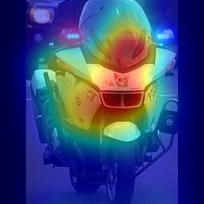

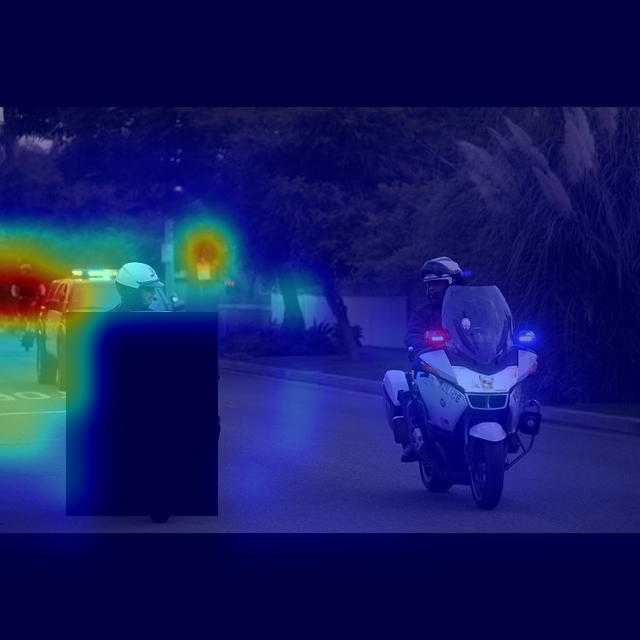

In [8]:
plt.Figure(dpi=300)

decoder_attention = g['decoder_attentions'].mean(0)
d_att = last_n_layer_att(decoder_attention, 'all')
t_att, l_att, c_att = decompose_att_vector(d_att)
t_att = reshape_2d_att(t_att)
make_heatmap(entry, torch.tensor(t_att), config.dir, mode='target')

c_att = reshape_2d_att(c_att)
make_heatmap(entry, torch.tensor(c_att), config.dir, mode='context', mask_out_target=True)

([<matplotlib.axis.YTick at 0x7fa7a49f0c40>,
 [Text(0, 0, 'x1'),
  Text(0, 1, 'x2'),
  Text(0, 2, 'y1'),
  Text(0, 3, 'y2'),
  Text(0, 4, 'area')])

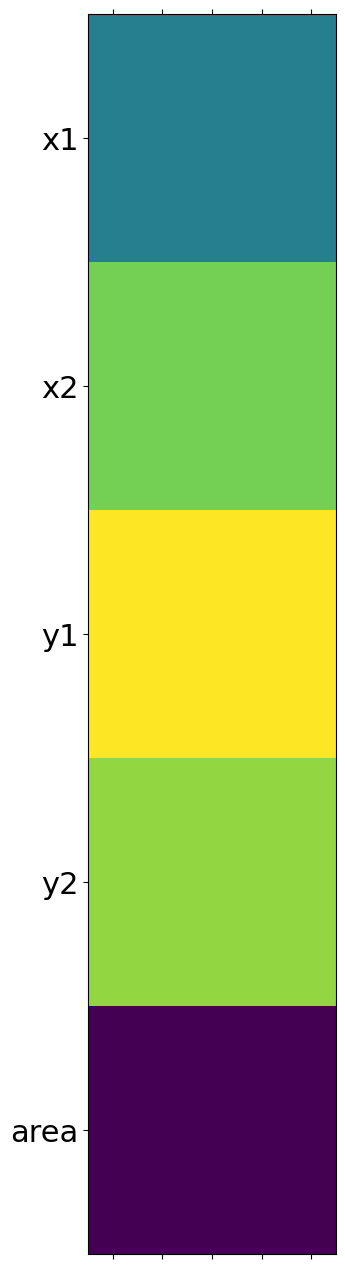

In [9]:
plt.rcParams.update({
    'xtick.minor.bottom':False,
    'font.size': 22, 
    'xtick.top': False,
    'xtick.bottom': False,
    'xtick.labelbottom': False
})

plt.matshow(l_att.reshape(-1, 1))
plt.yticks(range(5), 'x1 x2 y1 y2 area'.split())